In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from sklearn.metrics import confusion_matrix
import seaborn as sns 
from skimage.color import label2rgb
from lime import lime_image

In [16]:
def plot_confusion_matrix(model):
    '''
    Plot confusion matrix of the model

    Parameter: model - model of the data

    Returns: confusion matrix
    '''
    
    names = ['0-20', '21-26', '27-35', '36-50', '51+']

    y_pred=model.predict(test_generator) 
    y_pred=np.argmax(y_pred, axis=-1)

    CM = confusion_matrix(test_generator.classes, y_pred)

    ax = plt.axes()
    sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=names, 
           yticklabels=names, ax = ax)
    ax.set_title('Confusion matrix')
    plt.show();

In [19]:
def plot_lime(model, generator):
    '''
    Plots explaination of the model using LIME

    Parameter:
        model - model of the data
        generator - ImageGenerator 

    Returns: plots LIME images
    '''
    
    explainer = lime_image.LimeImageExplainer()

    img, label = generator.next()

    explanation = explainer.explain_instance(img[0].astype('double'), 
                                            model.predict)

    y_pred=model.predict(img) 
    classes_x=np.argmax(y_pred, axis=1)

    temp, mask = explanation.get_image_and_mask(classes_x[0], positive_only=True, num_features=5, hide_rest=False)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
    ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    ax1.set_title('Positive Regions for {}'.format(classes_x[0]))
    temp, mask = explanation.get_image_and_mask(classes_x[0], positive_only=False, num_features=10, hide_rest=False)
    ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
    ax2.set_title('Positive/Negative Regions for {}'.format(classes_x[0]))

In [2]:
train_dir = 'Human_Face_Regonition_Images\\split2\\train'
validation_dir = 'Human_Face_Regonition_Images\\split2\\validation'
test_dir = 'Human_Face_Regonition_Images\\split2\\test'

In [3]:
data_gen_aug = ImageDataGenerator(rescale=1./255, 
                                        rotation_range=30, 
                                        horizontal_flip=True)
                                        
train_generator_aug = data_gen_aug.flow_from_directory(train_dir, target_size=(256, 256), batch_size=128)

validation_generator_aug = data_gen_aug.flow_from_directory(validation_dir, target_size=(256, 256), batch_size=128)

test_data_gen= ImageDataGenerator(rescale=1./255)

test_generator = test_data_gen.flow_from_directory(test_dir, target_size=(256, 256), batch_size=32)

Found 16000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.
Found 3108 images belonging to 5 classes.


The second and third models with pretrained models have similar accuracy scores. So, we will look at the confusion matrix to choose the final model.

In [5]:
model1 = models.load_model('models/pretrained_model2.h5')
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               3

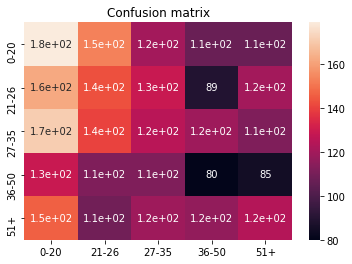

In [20]:
plot_confusion_matrix(model1)

This model seems to predict the ages to be 0-20 more than other ages. 

In [21]:
model2 = models.load_model('models/pretrained_model3.h5')
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 64)          294976    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               1

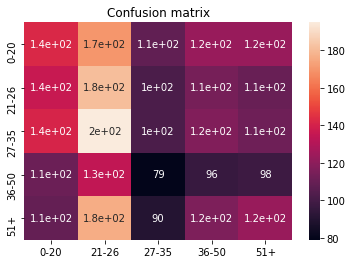

In [23]:
plot_confusion_matrix(model2)

This model seems to predict the ages to be 21-26 more than other ages.

The confusion matrix for the two models seems to be doing similar except that the first one predicts the age to be 0-20 more and the second model predicts the age to be 21-26 more. Since the first model did score 1% better, I will be choosing the first model to be the final model.

# LIME

Using LIME library, I will plot explainations of how the model is predicting the age. (I got the codes from [this website](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Faces%20and%20GradBoost.ipynb))

100%|██████████| 1000/1000 [01:20<00:00, 12.45it/s]


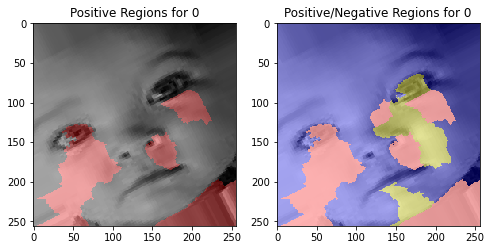

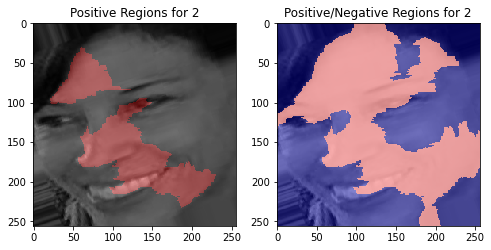

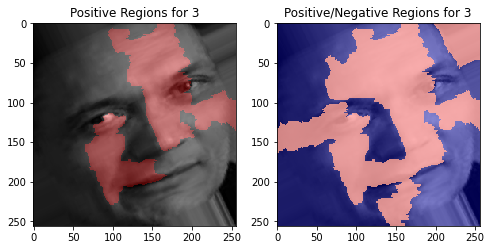

In [26]:
for n in range(3):
    plot_lime(model1, train_generator_aug)

The red highlighted ares in the images are what the model used to predict the ages and the other colors are contradicting explanations for other classes.